# Data Pre-processing
Steps:
1. Load the stock prices data for all companies
2. Create 200 datasets for each company (X & Y)
3. Data quality check and data cleansing
4. Save datasets into a Pickle file

# Step 1. Load stock prices data for all companies
1. Import libraries
2. Load 20 companies data
3. Calculate High-Low average

## Import libraries

In [1]:
# Import date, file and chart libraries
import math
import random
import pickle
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from numpy import array
from os import listdir
from os.path import isfile, join
from datetime import datetime
from collections import Counter
from numpy.random.mtrand import random_sample
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import MinMaxScaler
from pandas.api.types import is_numeric_dtype

## Read data files into data frames

In [2]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Read all files into a list of data frames and calculate the High Low average

# Get the file names of all files in the data folder
data_folder = "/content/drive/My Drive/Colab Notebooks/2. Data/20 Companies"
all_files = [f for f in listdir(data_folder)]
number_of_companies = len(all_files)
SP = [] # A list to store the stock price for each company
ticker_list = [] # A list to store the tickers
sector_list = [] # A list to store the sectors
sc = MinMaxScaler(feature_range = (0, 1)) # For scaling

# Loop for all files in the folder
for filename in all_files:
    # Load stock price data for 1 company into SP1
    SP1 = pd.read_csv(join(data_folder, filename), header=0)

    # Get the sector and company name from the file name
    sector = filename[:2]
    ticker = filename[2:len(filename)-4]
    ticker_list.append(ticker.strip())
    sector_list.append(sector.strip())
    
    # Add 3 columns: ID (sequential number), sector and company name
    SP1.insert(0, "ID", range(0, len(SP1)))
    SP1.insert(0, "Sector", sector.strip())
    SP1.insert(0, "Ticker", ticker.strip())
    
    # Calculate High-Low average and convert Date column from object to datetime
    SP1["HL_Avg"] = (SP1["High"] + SP1["Low"]) / 2 # Calculate the high-low average
    SP1["Date"] = pd.to_datetime(SP1["Date"])

    # Scale the data to between 0 and 1 (normalised)
    SP1[["HL_Avg_Norm", "Volume_Norm"]] = sc.fit_transform(SP1[["HL_Avg", "Volume"]])

    # Drop columns which are not required. Reorder the columns and display the data.
    SP1 = SP1.drop(columns=["Open", "Low", "High", "Close", "Adj Close"])
    SP1 = SP1.reindex(columns=["ID", "Sector", "Ticker", "Date", "HL_Avg", "Volume", "HL_Avg_Norm", "Volume_Norm"])
    SP.append(SP1)

## Plot the High Low Average

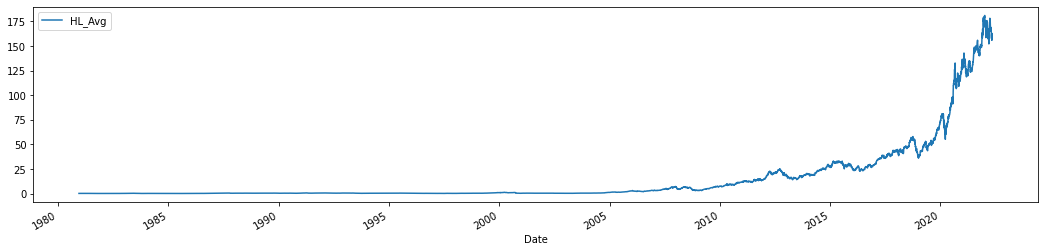

In [4]:
# Plot the High Low average of the first company to see the time series.
SP[0].plot.line(x="Date", y="HL_Avg", figsize=(18,4)) 

# Step 2. Create 200 random datasets for each company (X & Y)
1. Create a function to calculate 5% band
2. Create 200 random datasets (5 years data + 3 months later)

## Function to calculate 5% band

In [5]:
# Create a function to calculate 5% band i.e. 
#     0 to 5% = U1 (including 0), 5 to 10% = U2, 10 to 15% = U3, 15 to 20% = U4, >= U5.
#     <0 to -5% = D1, -5 to -10% = D2, -10 to -15% = D3, -15 to -20 = D4, <-20% = D5.
def calc_band(input_pct):
    if input_pct > 20: 
        band = 5
        prefix = 'U'
    elif input_pct < -20: 
        band = 5
        prefix = "D"
    elif input_pct >= 0:
        band = math.floor(input_pct / 5) + 1 # Floor(1/5) is 0 so to make it Band 1 we need to add 1
        prefix = "U"
    else:
        band = math.floor(input_pct / 5) # Floor(-1/5) is -1 so no need to add 1
        prefix = "D"
    return prefix + str(abs(band))

## Create 200 datasets x 20 companies

In [9]:
# Randomly create 50 datasets (5 year data + 3 months later)
TS_list = []
number_of_days = [] # Number of days in each dataset (for LSTM the number of days in each dataset must be the same)
number_of_datasets = 200 # x 20 companies = 4000 data sets (first 1000 for forecasting, remaining 3000 for ML training)

# Loop for each company
for c in range(number_of_companies):
    
    # Generate 50 random numbers. Minus 1500 because we are adding 5Y to from_date
    random.seed(42) # Seed it so the result is repeatable
    r = random.sample(range(0, len(SP[c])-1500), number_of_datasets) 
    
    # Initialise variables
    TS = {"X":[], "Y":[], "X_last_price":[], "Y_band":[], "forecast_from":[], "forecast_to":[], \
          "X_last_price_norm":[], "Y_band_norm":[]}
    # TS: time series dictionary, containing these 6 variables:
    # X: the 5 year prices that we forecast from
    # Y: the 1 week prices to be forecasted
    # X_last_price: The price on the last day in the 5 year period
    # Y_band: the band of Y Avg i.e. U1 means 0-3%
    # forecast_from: The beginning of the 1 week forecast period (day 65)
    # forecast_to The end of the 1 week forecast period (day 69)
    # X_last_price_norm: The normalised price on the last day in the 5 year period
    # Y_band_norm: the band of the Y Avg Norm, i.e. U1 means 0-3%
    
    # Create 200 datasets (ds)
    for ds in range (number_of_datasets): 
        
        # Initialise from_date with the date from random row, and to_date with from_date + 5 years
        from_date = SP[c].loc[r[ds]]["Date"]
        to_date = from_date + relativedelta(years = 5)

        # x is the 5 year prices
        x = SP[c].loc[((SP[c]["Date"] >= from_date) & (SP[c]["Date"] < to_date))].sort_values(by=["Date"])
        TS["X"].append(x)
        number_of_days.append(len(x))

        # y is the 1 week forecast prices, located 3 months after the 5 year dataset
        y_from_date = to_date + relativedelta(months = 3)
        y_to_date = y_from_date + relativedelta(weeks = 1)
        y = SP[c].loc[((SP[c]["Date"] >= y_from_date) & (SP[c]["Date"] < y_to_date))].sort_values(by=["Date"])
        TS["Y"].append(y)
        y_avg = y["HL_Avg"].mean() # Take the average of those 1 week prices
            
        # Compare y_avg to the last price in x, get the price gap in % and calculate the price band
        last_price = x.iloc[-1]["HL_Avg"]
        TS["X_last_price"].append(last_price)
        price_gap_pct = (y_avg - last_price) / last_price * 100
        band = calc_band(price_gap_pct)
        TS["Y_band"].append(band)

        # Calculate band for the normalised price
        y_avg_norm = y["HL_Avg_Norm"].mean() # Average of the normalised price
        last_price_norm =  x.iloc[-1]["HL_Avg_Norm"]
        TS["X_last_price_norm"].append(last_price_norm)
        price_gap_pct_norm = (y_avg_norm - last_price_norm) / last_price_norm * 100
        band_norm = calc_band(price_gap_pct_norm)
        TS["Y_band_norm"].append(band_norm)

        # Get the beginning and the end of the 1 week forecast period
        TS["forecast_from"].append(int(y.iloc[0]["ID"]) - int(x.iloc[-1]["ID"]))
        TS["forecast_to"].append(int(y.iloc[-1]["ID"]) - int(x.iloc[-1]["ID"]))

    TS_list.append(TS)

# Check the last company (Nike), variable X, 50th time series
TS_list[19]["X"][199]

ID Sector Ticker       Date    HL_Avg    Volume  HL_Avg_Norm  \
887    887     CD    NKE 1984-06-05  0.154297   1305600     0.000259   
888    888     CD    NKE 1984-06-06  0.152344   1824000     0.000248   
889    889     CD    NKE 1984-06-07  0.154297   1056000     0.000259   
890    890     CD    NKE 1984-06-08  0.157226   8102400     0.000276   
891    891     CD    NKE 1984-06-11  0.160156   1190400     0.000292   
...    ...    ...    ...        ...       ...       ...          ...   
2145  2145     CD    NKE 1989-05-26  0.589844  10649600     0.002717   
2146  2146     CD    NKE 1989-05-30  0.589843  18035200     0.002717   
2147  2147     CD    NKE 1989-05-31  0.590820  36377600     0.002723   
2148  2148     CD    NKE 1989-06-01  0.596680  19891200     0.002756   
2149  2149     CD    NKE 1989-06-02  0.611328  94860800     0.002838   

      Volume_Norm  
887      0.008292  
888      0.011585  
889      0.006707  
890      0.051462  
891      0.007561  
...           ...  
2145     0.067640  
2146     0.114549  
2147     0.231049  
2148     0.126337  
2149     0.602499  

[1263 rows x 8 columns]

In [10]:
TS_list[19]["Y"][199]

ID Sector Ticker       Date    HL_Avg    Volume  HL_Avg_Norm  \
2214  2214     CD    NKE 1989-09-05  0.813477  23852800     0.003979   
2215  2215     CD    NKE 1989-09-06  0.806640  12313600     0.003941   
2216  2216     CD    NKE 1989-09-07  0.812500  15686400     0.003974   
2217  2217     CD    NKE 1989-09-08  0.845703  41593600     0.004161   
2218  2218     CD    NKE 1989-09-11  0.880859  39232000     0.004359   

      Volume_Norm  
2214     0.151499  
2215     0.078209  
2216     0.099631  
2217     0.264178  
2218     0.249178

## Put those 4000 datasets into X and Y

In [27]:
# Put those 4000 datasets into X and Y 
#   first 1000 for forecasting (ML & statistical models)
#   remaining 3000 for ML models training
# Put the date as the first column for ES model
X = [] # 4000 X time series datasets 
Y = [] # 4000 Y actual prices (1 week stock prices, 3 months after X)
Metadata = [] # the company ID, ticker, dataset ID, sector, Y gap, Y days 
# Y_gap is the number of rows of data between the last row in X and the first row in Y
# Y_days is the number of days in Y

for c in range(number_of_companies):
    for ds in range(number_of_datasets):
        # Store the Data and HL Average in X variable
        X.append(TS_list[c]["X"][ds][["Date","HL_Avg","Volume","HL_Avg_Norm","Volume_Norm"]])
        
        # Calculate Y Difference and Y Band
        Y_Avg  = np.average(TS_list[c]["Y"][ds]["HL_Avg"])
        X_Last = TS_list[c]["X_last_price"][ds]
        Y_Diff = (Y_Avg - X_Last) / X_Last * 100
        Y_Band = calc_band(Y_Diff)

        # Calculate Y Avg for the normalised price
        Y_Avg_Norm  = np.average(TS_list[c]["Y"][ds]["HL_Avg_Norm"])
        X_Last_Norm = TS_list[c]["X_last_price_norm"][ds]
        Y_Diff_Norm = (Y_Avg_Norm - X_Last_Norm) / X_Last_Norm * 100
        Y_Band_Norm = calc_band(Y_Diff_Norm)

        # How many rows/data between the last day in X and the first day in Y 
        # (required to get the correct LSTM prediction)
        Y_Gap = TS_list[c]["Y"][ds]["ID"].iloc[0] - TS_list[c]["X"][ds]["ID"].iloc[-1]
        
        # How many days in Y (required to get the correct LSTM prediction)
        Y_Days = len(TS_list[c]["Y"][ds]["ID"])

        # Store Y average price, X last price, Y Diff, Y Band, Y Gap, Y Days, 
        #       Y Avg Norm, X last price norm, Y Band Norm in Y variable
        Y.append([Y_Avg, X_Last, Y_Diff, Y_Band, Y_Gap, Y_Days, Y_Avg_Norm, X_Last_Norm, Y_Band_Norm])

        # Store the Company ID, ticker, sector, Dataset ID, Y gap and Y days into metadata
        Metadata.append([c, ticker_list[c], sector_list[c], ds])

print(len(X), len(Y), len(Metadata))
#X: 4000 datasets, each has 1230-1267 rows (days) x 2 columns (date and HL Avg)
print(Y[0])
#Y: 4000 datasets, 6 columns: Y average price, X last price, Y Diff, Y Band, Y Gap, Y Days, Y Avg Norm, Y Band Norm
#metadata: 4000 metadata (Company ID, ticker, sector, Dataset ID)
print(Metadata[0], Metadata[-1])

4000 4000 4000
[0.48337050000000004, 0.4743305, 1.9058441318869541, 'U1', 65, 5, 0.0023979612733380485, 0.0023480111716386197, 'U1']
[0, 'AAPL', 'IT', 0] [19, 'NKE', 'CD', 199]


# Step 3. Data quality check and data cleansing

## Check Null and invalid values

In [29]:
# Check for null or invalid date, price and volume
Null_List = []
Invalid_List = []

for DS in range(len(X)):
    Null_Date   = X[DS]["Date"].isnull().sum()
    Null_Price  = X[DS]["HL_Avg"].isnull().sum()
    Null_Volume = X[DS]["Volume"].isnull().sum()
    Null_List.append([Null_Date, Null_Price, Null_Volume])

    Invalid_Date   = pd.to_datetime(X[DS]["Date"], errors="coerce").isnull().sum()
    Invalid_Price  = int(not(is_numeric_dtype(X[DS]["HL_Avg"])))
    Invalid_Volume = int(not(is_numeric_dtype(X[DS]["Volume"])))
    Invalid_List.append([Invalid_Date, Invalid_Price, Invalid_Volume])

Null_DF    = pd.DataFrame(Null_List,    columns = ["Date","Price","Volume"])
Invalid_DF = pd.DataFrame(Invalid_List, columns = ["Date","Price","Volume"])

In [30]:
print("Number of datasets with NULL date     :", sum(Null_DF["Date"]))
print("Number of datasets with NULL price    :", sum(Null_DF["Price"]))
print("Number of datasets with NULL volume   :", sum(Null_DF["Volume"]))
print("Number of datasets with invalid date  :", sum(Invalid_DF["Date"]))
print("Number of datasets with invalid price :", sum(Invalid_DF["Price"]))
print("Number of datasets with invalid volume:", sum(Invalid_DF["Volume"]))

Number of datasets with NULL date     : 0
Number of datasets with NULL price    : 0
Number of datasets with NULL volume   : 0
Number of datasets with invalid date  : 0
Number of datasets with invalid price : 0
Number of datasets with invalid volume: 0


## Check negative prices and volume

In [31]:
## Check negative prices and volume
Negative_List = []

for DS in range(len(X)):
    Negative_Price  = (X[DS]["HL_Avg"] < 0).sum()
    Negative_Volume = (X[DS]["Volume"] < 0).sum()
    Negative_List.append([Negative_Price, Negative_Volume])

Negative_DF = pd.DataFrame(Negative_List, columns = ["Price","Volume"])
print("Number of datasets with negative prices :", sum(Negative_DF["Price"]))
print("Number of datasets with negative volume :", sum(Negative_DF["Volume"]))

Number of datasets with negative prices : 0
Number of datasets with negative volume : 0


## Check Y Gap and Y Days

In [32]:
# Convert dataset Y into a Pandas data frame
Y_DF = pd.DataFrame(Y, columns = ["Y_Avg", "X_Last", "Y_Diff", "Y_Band", "Y_Gap", "Y_Days", \
                                  "Y_Avg_Norm", "X_Last_Price", "Y_Band_Norm"])

In [33]:
# Count the values in Y Gap
Y_DF["Y_Gap"].value_counts()
# There are 7 rows with Y Gap < 60
# Y Gap = 59 : 3
# Y Gap = 54 : 2
# Y Gap = 53 : 2

65    1264
64     966
63     695
66     507
62     424
61     126
60      11
59       3
54       2
53       2
Name: Y_Gap, dtype: int64

In [34]:
# Count the values in Y Days
Y_DF["Y_Days"].value_counts()
# There are 4 rows with Y Days < 4
# Y Days = 3 : 1
# Y Days = 2 : 1
# Y Days = 1 : 2

5    3365
4     631
1       2
3       1
2       1
Name: Y_Days, dtype: int64

In [35]:
# Display rows with Y Gap < 60 or Y Days < 4
Y_DF.loc[(Y_DF["Y_Gap"] < 60) | (Y_DF["Y_Days"] < 4)] # 11 rows

Y_Avg     X_Last     Y_Diff Y_Band  Y_Gap  Y_Days  Y_Avg_Norm  \
1202   1.453105   1.450401   0.186452     U1     59       5    0.009768   
1402   5.407393   5.620907  -3.798577     D1     54       4    0.012096   
1417   5.078679   6.028076 -15.749587     D4     59       5    0.010679   
1423   5.673045   5.720217  -0.824650     D1     53       4    0.013241   
1569  34.149697  44.479456 -23.223664     D5     64       1    0.136018   
2164   9.235000   7.075000  30.530035     U5     66       3    0.155009   
2602   0.645616   0.633680   1.883579     U1     54       4    0.002701   
2617   0.751476   0.694445   8.212478     U2     59       5    0.003273   
2623   0.698785   0.619358  12.824065     U3     53       4    0.002988   
2769  55.655000  51.010001   9.106058     U2     64       1    0.299681   
3940   6.105937   5.183750  17.789969     U4     65       2    0.033848   

      X_Last_Price Y_Band_Norm  
1202      0.009742          U1  
1402      0.013016          D2  
1417      0.014772          D5  
1423      0.013445          D1  
1569      0.180555          D5  
2164      0.115071          U5  
2602      0.002637          U1  
2617      0.002965          U3  
2623      0.002560          U4  
2769      0.274604          U2  
3940      0.028643          U4

## Remove rows with DQ issues

In [36]:
# Get the index of the rows to be removed
Rows_To_Be_Removed = Y_DF.index[(Y_DF["Y_Gap"] < 60) | (Y_DF["Y_Days"] < 4)].tolist() # 11 rows
Rows_To_Be_Removed # [1202, 1402, 1417, 1423, 1569, 2164, 2602, 2617, 2623, 2769, 3940]

[1202, 1402, 1417, 1423, 1569, 2164, 2602, 2617, 2623, 2769, 3940]

In [37]:
# Remove pages with Y Gap < 60 or Y Days < 4 from dataset X
X = np.delete(X, Rows_To_Be_Removed)  # Takes 1 minute
print(len(X)) # 3989 rows left in dataset X

3989


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [38]:
# Remove rows with Y Gap < 60 or Y Days < 4 from dataset Y
Y_DF = Y_DF.loc[(Y_DF["Y_Gap"] >= 60) & (Y_DF["Y_Days"] >= 4)]
print(len(Y_DF)) # 3989 rows left in dataset Y

3989


In [39]:
# Convert Y dataframe back to Numpy array for saving
Y = Y_DF.to_numpy()
print(len(Y)) # 3989 rows 

3989


In [40]:
# Delete rows with DQ issues from the Metadata
Metadata = np.delete(Metadata, Rows_To_Be_Removed, axis = 0)
print(len(Metadata))

3989


# Step 4. Save datasets into Pickle files

In [41]:
# Save X & Y scaled datasets into a Pickle file
dataset_path = "/content/drive/My Drive/Colab Notebooks/3. Code/3. Compare/Dataset/"

with open(dataset_path + "Dataset V2.pickle", "wb") as f:
    pickle.dump(X, f)
    pickle.dump(Y, f) #Y_Avg, X_Last, Y_Diff, Y_Band, Y_Gap, Y_Days, Y_Avg_Norm, X_Last_Norm, Y_Band_Norm
    pickle.dump(Metadata, f) # Company ID, ticker, sector, Dataset ID
f.close()